<h1 style="text-align: center;" markdown="1"><font color=green>Kaggle Zillow Competition</font> </h1>

<font color=green>**Description**: </font>
    https://www.kaggle.com/c/zillow-prize-1 

<font color=green>**Objective**:</font>  Build a model to improve the Zestimate residual error.  <font color=green>$logerror=log(Zestimate)−log(SalePrice)$ </font> 
***
<font color=green> ** Table of contents **</font> 
1. [Load data](#section_1)   
1. [Check data](#section_2)  
1. [Merge & clean data](#section_3)      
1. [Prepare for training](#section_4)
   -  [feature engineering](#section_4_a)
   -  [additional features via SQL](#section_4_b)
   -  [impute missing values](#section_4_c) 
   -  [check feature importance](#section_4_d)
       - [XgBoost feature importance](#section_4_d_1)
       - [initial look at some features](#section_4_d_2)
   -  [generate training & testing sets](#section_4_e)
1. [Train models](#section_5) 
   -  [LightGBM](#section_5_a)
   -  [XgBoost](#section_5_b) 
   -  [random forest](#section_5_c) 
   -  [elastic net](#section_5_d) 
   -  [catboost](#section_5_e) 
1. [Plots](#section_6)
plot learning curve & visualize result of each model (roc auc )     
1. [Comparisons](#section_7)
ensemble & compare again 



## import modules

In [344]:
import pandas as pd
import numpy as np
from scipy import stats
from pylab import rcParams

# ML models
import pickle
import xgboost as xgb
import lightgbm as lgb
from sklearn import linear_model
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.metrics import explained_variance_score, mean_absolute_error

# time series models
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# Datetime operations
import time

# Visualisations
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.axes import Subplot
import seaborn as sns
plt.style.use('fivethirtyeight')
import pickle
import ggplot
import warnings

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

<a id="section_1"></a>
#  1.  Load data

In [375]:
df_properties_2016 = pd.read_csv('/Users/fangjie/Workspace/data-science/competitions/zillow/properties_2016.csv',low_memory = False)
df_properties_2017 = pd.read_csv('/Users/fangjie/Workspace/data-science/competitions/zillow/properties_2017.csv',low_memory = False)
df_transactions_2016 = pd.read_csv('/Users/fangjie/Workspace/data-science/competitions/zillow/train_2016_v2.csv',parse_dates=['transactiondate'],low_memory = False)
df_transactions_2017 = pd.read_csv('/Users/fangjie/Workspace/data-science/competitions/zillow/train_2017.csv',parse_dates=['transactiondate'],low_memory = False)
sample_submission = pd.read_csv('/Users/fangjie/Workspace/data-science/competitions/zillow/sample_submission.csv', low_memory = False)


<a id="section_2"></a>
# 2. Check data

In [346]:
#df_transactions_2016.head() 
#df_transactions_2017.head()
df_properties_2016.head()
#df_properties_2017.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [347]:
#df_transactions_2016.shape
#df_transactions_2017.shape
df_properties_2016.shape
#df_properties_2017.shape

(2985217, 58)

In [348]:
df_transactions_2016.dtypes
#df_transactions_2017.shape
#df_properties_2016.shape
#df_properties_2017.shape

parcelid                    int64
logerror                  float64
transactiondate    datetime64[ns]
dtype: object

In [349]:
#check uniqueness of parcelid
df_properties_2016.parcelid.unique().shape[0] == df_properties_2016.parcelid.shape[0]

True

In [350]:
df_train_2016 = pd.merge(df_transactions_2016, df_properties_2016, how = 'left', on = 'parcelid')
df_train_2017 = pd.merge(df_transactions_2017, df_properties_2017, how = 'left', on = 'parcelid')
df_train.dtypes

TaxScore                                              float64
ValueRatio                                            float64
airconditioningtypeid                                 float64
architecturalstyletypeid                              float64
assessmentyear                                        float64
basementsqft                                          float64
bathroomcnt                                           float64
bedroomcnt                                            float64
buildingclasstypeid                                   float64
buildingqualitytypeid                                 float64
calculatedbathnbr                                     float64
calculatedfinishedsquarefeet                          float64
censustractandblock                                   float64
decktypeid                                            float64
f_cat_median_year_in_rawcensustractandblock           float64
f_cat_median_year_in_regionidcity                     float64
f_cat_me

In [351]:
df_train.describe()

,TaxScore,ValueRatio,airconditioningtypeid,architecturalstyletypeid,assessmentyear,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,f_num_month,f_num_quarter,f_num_monthly_avg_logerror,f_num_monthly_stddev_logerror,f_num_quarterly_avg_logerror,f_num_quarterly_stddev_logerror
count,1.678410e+05,167841.000000,53788.000000,468.000000,167854.000000,93.000000,167854.000000,167854.000000,31.000000,107173.000000,...,109056.000000,5039.000000,165.000000,166828.000000,167888.000000,167888.000000,167888.000000,167888.000000,167888.000000,167888.000000
mean,7.051045e+09,77.660173,1.814345,7.299145,2015.462181,695.376344,2.288265,3.041739,3.967742,6.015461,...,1.110365,307.919032,271.260606,1968.569311,5.485437,2.160845,0.013906,0.165224,0.016095,0.172686
std,9.887881e+10,45.426310,2.970239,2.719633,0.498569,583.952144,1.000835,1.149134,0.179605,1.882799,...,0.988168,227.430960,293.611447,23.777202,2.641648,0.874374,0.003957,0.012063,0.003442,0.007780
min,3.423772e+04,0.009129,1.000000,2.000000,2015.000000,38.000000,0.000000,0.000000,3.000000,1.000000,...,1.000000,11.000000,12.000000,1824.000000,1.000000,1.000000,0.008849,0.134488,0.008849,0.162658
25%,5.667888e+08,72.129814,1.000000,7.000000,2015.000000,280.000000,2.000000,2.000000,4.000000,4.000000,...,1.000000,175.000000,88.000000,1953.000000,3.000000,1.000000,0.010421,0.157046,0.012199,0.163923
50%,1.551562e+09,80.346664,1.000000,7.000000,2015.000000,588.000000,2.000000,3.000000,4.000000,7.000000,...,1.000000,252.000000,160.000000,1970.000000,6.000000,2.000000,0.013941,0.163154,0.018463,0.172725
75%,3.772205e+09,84.974756,1.000000,7.000000,2016.000000,819.000000,3.000000,4.000000,4.000000,7.000000,...,1.000000,375.000000,320.000000,1987.000000,8.000000,3.000000,0.018463,0.172725,0.019012,0.181878
max,2.878125e+13,10669.578381,13.000000,21.000000,2016.000000,3560.000000,20.000000,16.000000,4.000000,12.000000,...,237.000000,3191.000000,1366.000000,2016.000000,12.000000,4.000000,0.019829,0.189896,0.019012,0.181878


### check logerror data

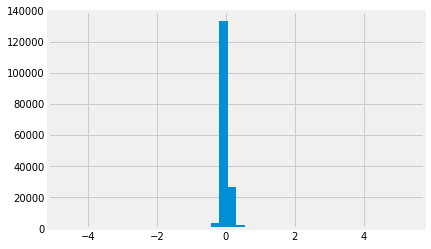

In [352]:
df_train.logerror.hist(bins = 40)
# this looks weird - there seems to be some extreme outliers, let me remove them and plot again

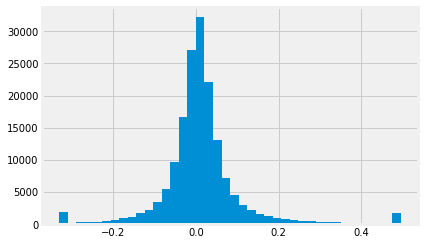

In [353]:
ulimit = np.percentile(df_train.logerror.values, 99)
llimit = np.percentile(df_train.logerror.values, 1)
df_train['logerror'].ix[df_train['logerror']>ulimit] = ulimit
df_train['logerror'].ix[df_train['logerror']<llimit] = llimit

df_train.logerror.hist(bins = 40)

### check missing values

In [354]:
# check missing values
df_nan = df_properties.isnull().sum(axis=0).reset_index()
df_nan.head()
df_nan.columns = ['column_name', 'nan_count']
df_nan = df_nan.ix[df_nan['nan_count']>0]
df_nan['nan_rate'] = df_nan['nan_count']*100.0/ df_properties.shape[0]
df_nan = df_nan.sort_values(by='nan_rate',ascending=False)
df_nan.head(10)

,column_name,nan_count,nan_rate
41,storytypeid,2983594,99.945632
3,basementsqft,2983590,99.945498
46,yardbuildingsqft26,2982571,99.911363
49,fireplaceflag,2980054,99.827048
2,architecturalstyletypeid,2979156,99.796966
43,typeconstructiontypeid,2978471,99.774020
13,finishedsquarefeet13,2977546,99.743034
6,buildingclasstypeid,2972486,99.573532
29,pooltypeid10,2968211,99.430326
9,decktypeid,2967838,99.417831


In [355]:
# there are a lot of fields that have huge percentage of missing values
# need to remove some if it gets too extreme cuz that will cause overfitting problems

<a id="section_3"></a>
# 3. Merge data 

In [423]:
# assign 2017 tax data to NULL due to info leak
# df_train_2017[['structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'taxamount']] = np.nan
#df = pd.merge(left=df_properties, right=df_transactions, on='parcelid')
#df_pred = pd.merge(left=df_properties, right=df_transactions.drop_duplicates(subset='parcelid',keep='first'), on='parcelid', how='left')
# merge the two set 
df_train = pd.concat([df_train_2016, df_train_2017], axis = 0)
df_pred_2016 = pd.merge(sample_submission[['ParcelId']], df_properties_2016.rename(columns = {'parcelid': 'ParcelId'}), 
                how = 'left', on = 'ParcelId')
df_pred_2017 = pd.merge(sample_submission[['ParcelId']], df_properties_2017.rename(columns = {'parcelid': 'ParcelId'}), 
                how = 'left', on = 'ParcelId')

In [357]:
(df_train['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    162541
2      2660
3         9
Name: parcelid, dtype: int64

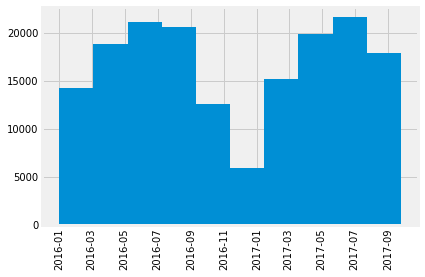

In [358]:
df_train.transactiondate.hist(xrot=90)

In [359]:
df_pred_2016.shape

(2985217, 58)

In [360]:
sample_submission.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


In [361]:
df_pred_2016.columns

Index([u'ParcelId', u'airconditioningtypeid', u'architecturalstyletypeid',
       u'basementsqft', u'bathroomcnt', u'bedroomcnt', u'buildingclasstypeid',
       u'buildingqualitytypeid', u'calculatedbathnbr', u'decktypeid',
       u'finishedfloor1squarefeet', u'calculatedfinishedsquarefeet',
       u'finishedsquarefeet12', u'finishedsquarefeet13',
       u'finishedsquarefeet15', u'finishedsquarefeet50',
       u'finishedsquarefeet6', u'fips', u'fireplacecnt', u'fullbathcnt',
       u'garagecarcnt', u'garagetotalsqft', u'hashottuborspa',
       u'heatingorsystemtypeid', u'latitude', u'longitude',
       u'lotsizesquarefeet', u'poolcnt', u'poolsizesum', u'pooltypeid10',
       u'pooltypeid2', u'pooltypeid7', u'propertycountylandusecode',
       u'propertylandusetypeid', u'propertyzoningdesc',
       u'rawcensustractandblock', u'regionidcity', u'regionidcounty',
       u'regionidneighborhood', u'regionidzip', u'roomcnt', u'storytypeid',
       u'threequarterbathnbr', u'typeconstructiontyp

In [390]:
df_train.columns

Index([u'parcelid', u'logerror', u'transactiondate', u'airconditioningtypeid',
       u'architecturalstyletypeid', u'basementsqft', u'bathroomcnt',
       u'bedroomcnt', u'buildingclasstypeid', u'buildingqualitytypeid',
       ...
       u'f_num_n_prop_in_regionidcity', u'f_cat_median_year_in_regionidcity',
       u'f_num_how_new_in_regionidcity', u'f_num_median_lat_in_regionidcity',
       u'f_num_median_lon_in_regionidcity',
       u'f_num_n_prop_in_rawcensustractandblock',
       u'f_cat_median_year_in_rawcensustractandblock',
       u'f_num_how_new_in_rawcensustractandblock',
       u'f_num_median_lat_in_rawcensustractandblock',
       u'f_num_median_lon_in_rawcensustractandblock'],
      dtype='object', length=105)

<a id="section_4"></a>
# 4. Prepare data for training

<a id="section_4_a"></a>
## 4a. feature engineering

In [400]:
for region in parcel_location_variables:

    #### COUNT OF PROPERTIES ####
    # number of properties in the zipcode
    group = df_pred_2017[region].value_counts().to_dict()
    df_pred_2017['f_num_n_prop_in_'+region] = df_pred_2017[region].map(group)
    df_train_2017['f_num_n_prop_in_'+region] = df_train_2017[region].map(group)
    
    ##### HOW NEW IS THIS BUILDING COMPARING TO OTHER BUILDINGS #####
    group = df_pred_2017.groupby(region)['yearbuilt'].aggregate('median').to_dict()
    df_pred_2017['f_cat_median_year_in_'+region] = df_pred_2017[region].map(group)
    df_train_2017['f_cat_median_year_in_'+region] = df_train_2017[region].map(group)
    
    df_pred_2017['f_num_how_new_in_'+region] = df_pred_2017['yearbuilt'] - df_pred_2017['f_cat_median_year_in_'+region]
    df_train_2017['f_num_how_new_in_'+region] = df_train_2017['yearbuilt'] - df_train_2017['f_cat_median_year_in_'+region]

    # Neighborhood latitude and longitude
    group = df_pred_2017.groupby(region)['latitude'].aggregate('median').to_dict()
    df_pred_2017['f_num_median_lat_in_'+region] = df_pred_2017[region].map(group)
    df_train_2017['f_num_median_lat_in_'+region] = df_train_2017[region].map(group)
    
    
    group = df_pred_2017.groupby(region)['longitude'].aggregate('median').to_dict()
    df_pred_2017['f_num_median_lon_in_'+region] = df_pred_2017[region].map(group)
    df_train_2017['f_num_median_lon_in_'+region] = df_train_2017[region].map(group)

    #Average structuretaxvaluedollarcnt by city
    group = df_pred_2017.groupby(region)['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
    df_pred_2017['f_num_Avg-structuretaxvaluedollarcnt'] = df_pred_2017['regionidcity'].map(group)
    df_train_2017['f_num_Avg-structuretaxvaluedollarcnt'] = df_train_2017['regionidcity'].map(group)

    #Deviation away from average
    df_pred_2017['f_num_Dev-structuretaxvaluedollarcnt'] = abs((df_pred_2017['structuretaxvaluedollarcnt'] - df_pred_2017['f_num_Avg-structuretaxvaluedollarcnt']))/df_pred_2017['f_num_Avg-structuretaxvaluedollarcnt']
    df_train_2017['f_num_Dev-structuretaxvaluedollarcnt'] = abs((df_train_2017['structuretaxvaluedollarcnt'] - df_train_2017['f_num_Avg-structuretaxvaluedollarcnt']))/df_train_2017['f_num_Avg-structuretaxvaluedollarcnt']

In [401]:
def add_date_features(df):
    #df["transaction_year"] = df["transactiondate"].dt.year
    #df["transaction_month"] = (df["transactiondate"].dt.year - 2016)*12 + df["transactiondate"].dt.month
    
    df["transaction_month"] = df["transactiondate"].dt.month
    df["transaction_quarter"] = df["transactiondate"].dt.quarter
    
    # df.drop(["transactiondate"], inplace=True, axis=1)

    #error in calculation of the finished living area of home
    df['f_num_LivingAreaError'] = df['calculatedfinishedsquarefeet']/df['finishedsquarefeet12']

    #proportion of living area
    df['f_num_LivingAreaProp'] = df['calculatedfinishedsquarefeet']/df['lotsizesquarefeet']
    df['f_num_LivingAreaProp2'] = df['finishedsquarefeet12']/df['finishedsquarefeet15']

    #Amout of extra space
    df['f_num_ExtraSpace'] = df['lotsizesquarefeet'] - df['calculatedfinishedsquarefeet'] 
    df['f_num_ExtraSpace-2'] = df['finishedsquarefeet15'] - df['finishedsquarefeet12'] 

    #Total number of rooms
    df['f_num_TotalRooms'] = df['bathroomcnt']*df['bedroomcnt']

    #Average room size
    df['f_num_AvRoomSize'] = df['calculatedfinishedsquarefeet']/df['roomcnt'] 

    # Number of Extra rooms
    df['f_num_ExtraRooms'] = df['roomcnt'] - df['f_num_TotalRooms'] 

    #Ratio of the built structure value to land area
    df['f_num_ValueProp'] = df['structuretaxvaluedollarcnt']/df['landtaxvaluedollarcnt']

    #Does property have a garage, pool or hot tub and AC?
    df['f_num_GarPoolAC'] = ((df['garagecarcnt']>0) & (df['pooltypeid10']>0) & (df['airconditioningtypeid']!=5))*1 

    df["f_num_location"] = df["latitude"] + df["longitude"]
    df["f_num_locatiof_num_2"] = df["latitude"]*df["longitude"]
    df["f_num_locatiof_num_2round"] = df["f_num_locatiof_num_2"].round(-4)

    df["f_num_latitude-round"] = df["latitude"].round(-4)
    df["f_num_longitude-round"] = df["longitude"].round(-4)
    
    #polnomials of the variable
    df["f_num_structuretaxvaluedollarcnt-2"] = df["structuretaxvaluedollarcnt"] ** 2
    df["f_num_structuretaxvaluedollarcnt-3"] = df["structuretaxvaluedollarcnt"] ** 3

    #Ratio of tax of property over parcel
    df['ValueRatio'] = df['taxvaluedollarcnt']/df['taxamount']

    #TotalTaxScore
    df['TaxScore'] = df['taxvaluedollarcnt']*df['taxamount']

    #polnomials of tax delinquency year
    df["taxdelinquencyyear-2"] = df["taxdelinquencyyear"] ** 2
    df["taxdelinquencyyear-3"] = df["taxdelinquencyyear"] ** 3

    return df

In [402]:
df_train_2016 = add_date_features(df_train_2016)
df_train_2017 = add_date_features(df_train_2017)

In [403]:
parcel_location_variables = ['regionidneighborhood',
                                 'regionidzip', 
                                 'regionidcity', 
                                 #'censustrack',
                                 'rawcensustractandblock']

# through for all 2016 data:
for region in parcel_location_variables:

    #### COUNT OF PROPERTIES ####
    # number of properties in the zipcode
    group = df_pred_2016[region].value_counts().to_dict()
    df_pred_2016['f_num_n_prop_in_'+region] = df_pred_2016[region].map(group)
    df_train_2016['f_num_n_prop_in_'+region] = df_train_2016[region].map(group)
    
    ##### HOW NEW IS THIS BUILDING COMPARING TO OTHER BUILDINGS #####
    group = df_pred_2016.groupby(region)['yearbuilt'].aggregate('median').to_dict()
    df_pred_2016['f_cat_median_year_in_'+region] = df_pred_2016[region].map(group)
    df_train_2016['f_cat_median_year_in_'+region] = df_train_2016[region].map(group)
    
    df_pred_2016['f_num_how_new_in_'+region] = df_pred_2016['yearbuilt'] - df_pred_2016['f_cat_median_year_in_'+region]
    df_train_2016['f_num_how_new_in_'+region] = df_train_2016['yearbuilt'] - df_train_2016['f_cat_median_year_in_'+region]

    # Neighborhood latitude and longitude
    group = df_pred_2016.groupby(region)['latitude'].aggregate('median').to_dict()
    df_pred_2016['f_num_median_lat_in_'+region] = df_pred_2016[region].map(group)
    df_train_2016['f_num_median_lat_in_'+region] = df_train_2016[region].map(group)
    
    
    group = df_pred_2016.groupby(region)['longitude'].aggregate('median').to_dict()
    df_pred_2016['f_num_median_lon_in_'+region] = df_pred_2016[region].map(group)
    df_train_2016['f_num_median_lon_in_'+region] = df_train_2016[region].map(group)

    #Average structuretaxvaluedollarcnt by city
    group = df_pred_2016.groupby(region)['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
    df_pred_2016['f_num_Avg-structuretaxvaluedollarcnt'] = df_pred_2016['regionidcity'].map(group)
    df_train_2016['f_num_Avg-structuretaxvaluedollarcnt'] = df_train_2016['regionidcity'].map(group)

    #Deviation away from average
    df_pred_2016['f_num_Dev-structuretaxvaluedollarcnt'] = abs((df_pred_2016['structuretaxvaluedollarcnt'] - df_pred_2016['f_num_Avg-structuretaxvaluedollarcnt']))/df_pred_2016['f_num_Avg-structuretaxvaluedollarcnt']
    df_train_2016['f_num_Dev-structuretaxvaluedollarcnt'] = abs((df_train_2016['structuretaxvaluedollarcnt'] - df_train_2016['f_num_Avg-structuretaxvaluedollarcnt']))/df_train_2016['f_num_Avg-structuretaxvaluedollarcnt']

In [404]:
# and do it for 2017
for region in parcel_location_variables:

    #### COUNT OF PROPERTIES ####
    # number of properties in the zipcode
    group = df_pred_2017[region].value_counts().to_dict()
    df_pred_2017['f_num_n_prop_in_'+region] = df_pred_2017[region].map(group)
    df_train_2017['f_num_n_prop_in_'+region] = df_train_2017[region].map(group)
    
    ##### HOW NEW IS THIS BUILDING COMPARING TO OTHER BUILDINGS #####
    group = df_pred_2017.groupby(region)['yearbuilt'].aggregate('median').to_dict()
    df_pred_2017['f_cat_median_year_in_'+region] = df_pred_2017[region].map(group)
    df_train_2017['f_cat_median_year_in_'+region] = df_train_2017[region].map(group)
    
    df_pred_2017['f_num_how_new_in_'+region] = df_pred_2017['yearbuilt'] - df_pred_2017['f_cat_median_year_in_'+region]
    df_train_2017['f_num_how_new_in_'+region] = df_train_2017['yearbuilt'] - df_train_2017['f_cat_median_year_in_'+region]

    # Neighborhood latitude and longitude
    group = df_pred_2017.groupby(region)['latitude'].aggregate('median').to_dict()
    df_pred_2017['f_num_median_lat_in_'+region] = df_pred_2017[region].map(group)
    df_train_2017['f_num_median_lat_in_'+region] = df_train_2017[region].map(group)
    
    
    group = df_pred_2017.groupby(region)['longitude'].aggregate('median').to_dict()
    df_pred_2017['f_num_median_lon_in_'+region] = df_pred_2017[region].map(group)
    df_train_2017['f_num_median_lon_in_'+region] = df_train_2017[region].map(group)

    #Average structuretaxvaluedollarcnt by city
    group = df_pred_2017.groupby(region)['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
    df_pred_2017['f_num_Avg-structuretaxvaluedollarcnt'] = df_pred_2017['regionidcity'].map(group)
    df_train_2017['f_num_Avg-structuretaxvaluedollarcnt'] = df_train_2017['regionidcity'].map(group)

    #Deviation away from average
    df_pred_2017['f_num_Dev-structuretaxvaluedollarcnt'] = abs((df_pred_2017['structuretaxvaluedollarcnt'] - df_pred_2017['f_num_Avg-structuretaxvaluedollarcnt']))/df_pred_2017['f_num_Avg-structuretaxvaluedollarcnt']
    df_train_2017['f_num_Dev-structuretaxvaluedollarcnt'] = abs((df_train_2017['structuretaxvaluedollarcnt'] - df_train_2017['f_num_Avg-structuretaxvaluedollarcnt']))/df_train_2017['f_num_Avg-structuretaxvaluedollarcnt']

<a id="section_4_b"></a>
## 4b. add additiona features via SQL

In [405]:
!psql -d zillow -a -f /Users/fangjie/Workspace/data-science/competitions/zillow/sql_scripts/feature_engineering_time.sql

DROP TABLE IF EXISTS transactions_2016;
DROP TABLE
CREATE TABLE transactions_2016 (
	parcelid bigint, 
	logerror double precision,
	transactiondate varchar
);
CREATE TABLE
DROP TABLE IF EXISTS transactions_2017;
DROP TABLE
COPY transactions_2016
FROM '/Users/fangjie/Workspace/data-science/competitions/zillow/train_2016_v2.csv' DELIMITER ',' CSV HEADER;
COPY 90275
CREATE TABLE transactions_2017 (
	parcelid bigint, 
	logerror double precision,
	transactiondate varchar
);
CREATE TABLE
COPY transactions_2017
FROM '/Users/fangjie/Workspace/data-science/competitions/zillow/train_2017.csv' DELIMITER ',' CSV HEADER;
COPY 77613
DROP TABLE IF EXISTS transactions;
DROP TABLE
CREATE TABLE transactions AS
SELECT * FROM transactions_2016
UNION ALL
SELECT * FROM transactions_2017;
SELECT 167888
DROP TABLE IF EXISTS tmp_additional_temporal_information;
DROP TABLE
CREATE TABLE tmp_additional_temporal_information AS
SELECT 
    t.parcelid
    , t.logerror
    , t.transactiondate
    , substring(transact

In [406]:
d_features = pd.read_csv('/Users/fangjie/Workspace/data-science/competitions/zillow/2nd_monthly_transactions_features.csv')

In [407]:
df_train = pd.concat([df_train_2016, df_train_2017], axis = 0)
df_train['f_num_month'] = pd.to_datetime(df_train.transactiondate).dt.month.astype(int)
df_train['f_num_quarter'] = pd.to_datetime(df_train.transactiondate).dt.quarter.astype(int)

In [408]:
for m in [201610, 201611, 201612, 201710, 201711, 201712]:
    year = str(m)[:4]
    month = str(m)[4:]
    
    # avg log error, monthly
    group = df_train.groupby(df_train.f_num_month)['logerror'].aggregate('mean').to_dict()
    df_train['f_num_monthly_avg_logerror'] = df_train['f_num_month'].map(group)
    eval('df_pred_'+str(year))['f_num_monthly_avg_logerror'] = group[int(month)]
                                   
    # std dev log error, monthly
    group = df_train.groupby(df_train.f_num_month)['logerror'].aggregate('std').to_dict()
    df_train['f_num_monthly_stddev_logerror'] = df_train['f_num_month'].map(group)
    eval('df_pred_'+str(year))['f_num_monthly_stddev_logerror'] = group[int(month)]

    # avg log error, quarterly
    group = df_train.groupby(df_train.f_num_month)['logerror'].aggregate('mean').to_dict()
    df_train['f_num_quarterly_avg_logerror'] = df_train['f_num_quarter'].map(group)
    eval('df_pred_'+str(year))['f_num_quarterly_avg_logerror'] = group[4]
    
    # std dev log error, monthly
    group = df_train.groupby(df_train.f_num_month)['logerror'].aggregate('std').to_dict()
    df_train['f_num_quarterly_stddev_logerror'] = df_train['f_num_quarter'].map(group)
    eval('df_pred_'+str(year))['f_num_quarterly_stddev_logerror'] = group[4]
    

In [428]:
df = df_train
all_fields = set(df.columns)

# these are fields that are used to identify fields
identifiers = set(['transactiondate', 'parcelid'])

# log error that we want to model
label = set(['logerror'])

# the following are categorical features
feats_objects = set(
 ['taxdelinquencyflag',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'fireplaceflag',
 'hashottuborspa']
)

# the following are numerical features that should be treated as categorical features
feats_numeric_to_categorical = set([
    'airconditioningtypeid',
    'architecturalstyletypeid',
    'buildingqualitytypeid',
    'buildingclasstypeid',
    'decktypeid',
    'fips',
    'heatingorsystemtypeid',
    'propertylandusetypeid',
    'regionidcounty',
    'regionidcity',
    'regionidzip',
    'regionidneighborhood',
    'storytypeid',
    'typeconstructiontypeid',
    'yearbuilt',
    'assessmentyear',
    'taxdelinquencyyear'
])


# the rest are numeric features
feats_numeric = set([
    'basementsqft',
    'bathroomcnt',
    'bedroomcnt',
    'calculatedbathnbr',
    'threequarterbathnbr',
    'finishedfloor1squarefeet',
    'calculatedfinishedsquarefeet',
    'finishedsquarefeet6',
    'finishedsquarefeet12',
    'finishedsquarefeet13',
    'finishedsquarefeet15',
    'finishedsquarefeet50',
    'fireplacecnt',
    'fullbathcnt',
    'garagecarcnt',
    'garagetotalsqft',
    'hashottuborspa',
    'lotsizesquarefeet',
    'numberofstories',
    'poolcnt',
    'poolsizesum',
    'pooltypeid10',
    'pooltypeid2',
    'pooltypeid7',
    'roomcnt',
    'unitcnt',
    'yardbuildingsqft17',
    'yardbuildingsqft26',
    'taxvaluedollarcnt',
    'structuretaxvaluedollarcnt',
    'landtaxvaluedollarcnt',
    'taxamount'
])

feats_numerics_feature_engineered = set([col for col in df.columns if 'f_num' in col])


feats_categorical_feature_engineered = set([col for col in df.columns if 'f_cat' in col])


# fields that are thrown away for now
feats_for_consideration_later = set([
    'latitude',
    'longitude',
    'rawcensustractandblock',
    'censustractandblock',
])

In [410]:
feats_categorical = feats_numeric_to_categorical | feats_objects | feats_categorical_feature_engineered
feats_numeric = feats_numeric | feats_numerics_feature_engineered 
feats = feats_categorical | feats_numeric 

feats_categorical = list(feats_categorical)
feats_numeric = list(feats_numeric)
feats = list(feats)

In [429]:
feats_numeric

{'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedfloor1squarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'landtaxvaluedollarcnt',
 'lotsizesquarefeet',
 'numberofstories',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'roomcnt',
 'structuretaxvaluedollarcnt',
 'taxamount',
 'taxvaluedollarcnt',
 'threequarterbathnbr',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26'}

In [426]:
df_train = pd.concat([df_train_2016, df_train_2017], axis = 0)
df_train['f_num_month'] = pd.to_datetime(df_train.transactiondate).dt.month.astype(int)
df_train['f_num_quarter'] = pd.to_datetime(df_train.transactiondate).dt.quarter.astype(int)

In [412]:
df_pred_2016.head()

,ParcelId,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,f_num_median_lon_in_regionidcity,f_num_n_prop_in_rawcensustractandblock,f_cat_median_year_in_rawcensustractandblock,f_num_how_new_in_rawcensustractandblock,f_num_median_lat_in_rawcensustractandblock,f_num_median_lon_in_rawcensustractandblock,f_num_monthly_avg_logerror,f_num_monthly_stddev_logerror,f_num_quarterly_avg_logerror,f_num_quarterly_stddev_logerror
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,-118657093.5,10.0,1981.0,NaN,34148517.0,-118651951.0,0.019122,0.189896,0.008849,0.162658
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,-118657093.5,289.0,1970.0,NaN,34142656.0,-118625111.0,0.019122,0.189896,0.008849,0.162658
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,-118392977.5,1.0,NaN,NaN,33989359.0,-118394633.0,0.019122,0.189896,0.008849,0.162658
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,-118405049.0,29.0,1940.0,8.0,34147770.0,-118437123.0,0.019122,0.189896,0.008849,0.162658
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,-118405049.0,1.0,1947.0,0.0,34194168.0,-118385816.0,0.019122,0.189896,0.008849,0.162658


<a id="section_4_c"></a>
## 4c. impute missing data (non-linear)

In [413]:
df.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,f_cat_median_year_in_rawcensustractandblock,f_num_how_new_in_rawcensustractandblock,f_num_median_lat_in_rawcensustractandblock,f_num_median_lon_in_rawcensustractandblock,f_num_month,f_num_quarter,f_num_monthly_avg_logerror,f_num_monthly_stddev_logerror,f_num_quarterly_avg_logerror,f_num_quarterly_stddev_logerror
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,1959.0,0.0,34281281.0,-118492295.5,1,1,0.019012,0.172725,0.019012,0.172725
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,2014.0,0.0,33669368.0,-117677644.0,1,1,0.019012,0.172725,0.019012,0.172725
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,1937.0,3.0,34138109.5,-118175731.0,1,1,0.019012,0.172725,0.019012,0.172725
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,1987.0,0.0,33754700.0,-118308000.0,1,1,0.019012,0.172725,0.019012,0.172725
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,1981.0,0.0,33485118.0,-117699023.0,1,1,0.019012,0.172725,0.019012,0.172725


In [ ]:
# need to impute all these with a `missing` value first
df[feats_categorical_as_numeric] = df[feats_categorical_as_numeric].fillna(-1)
df_pred_2016[feats_categorical_as_numeric] = df_pred_2016[feats_categorical_as_numeric].fillna(-1)
df_pred_2017[feats_categorical_as_numeric] = df_pred_2017[feats_categorical_as_numeric].fillna(-1)

In [431]:
# use label encoder to encode all categorical variables
for column in feats_categorical:
    tmp = pd.concat([df[column], df_pred_2016[column], df_pred_2017[column]], axis = 0)
    encoder = LabelEncoder().fit(tmp.astype(str))
    df[column] = encoder.transform(df[column].astype(str)).astype(np.int32)
    df_pred_2016[column] = encoder.transform(df_pred_2016[column].astype(str)).astype(np.int32)
    df_pred_2017[column] = encoder.transform(df_pred_2017[column].astype(str)).astype(np.int32)

KeyError: 'f_cat_median_year_in_regionidneighborhood'

In [430]:
# for numeric variables, fill with a big negative number
df[feats_numeric] = df[feats_numeric].fillna(-999)

feats_numeric_not_contain_timeseries = [x for x in feats_numeric if "_logerror" not in x and "f_num_month" not in x and "f_num_quarter" not in x]

df_pred_2016[feats_numeric_not_contain_timeseries] = df_pred_2016[feats_numeric_not_contain_timeseries].fillna(-999)
df_pred_2017[feats_numeric_not_contain_timeseries] = df_pred_2017[feats_numeric_not_contain_timeseries].fillna(-999)

# imp =  Imputer(missing_values=np.nan, strategy="median", axis=0)
# # df[feats_numeric] = imp.fit_transform(df[feats_numeric])
# for feat in feats_numeric:
#     if df[feat].isnull().sum() < df.shape[0]:
#         df[[feat]] = imp.fit_transform(df[[feat]])
#     else:
#         df[feat] = 0

TypeError: unhashable type: 'set'

<a id="section_4_d"></a>
<a id="section_4_d_1"></a>
## 4d. check importance of features


In [422]:
df_tmp = df_train
train_y = df_tmp['logerror'].values
df_tmp = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'transaction_month',"hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(df_tmp, train_y, feature_names=df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)
# plot the important features #
fig, ax = plt.subplots(figsize=(10,15))
xgb.plot_importance(model, max_num_features=40, height=0.8, ax=ax)
plt.show()

ValueError: feature_names must have the same length as data

<a id="section_4_d_2"></a>
### take a peak at  tax amount, temporal, spatial features 

### check tax amount
tax seems to have very high importance, check it first

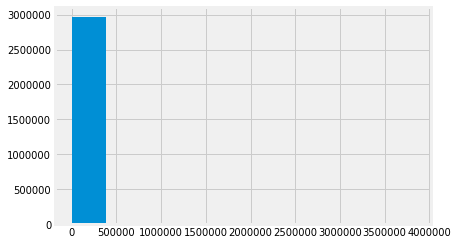

In [156]:
df_properties.taxamount.hist()
# it seems to be hugely skewed on the long tail end
# let me apply a log and look at it again

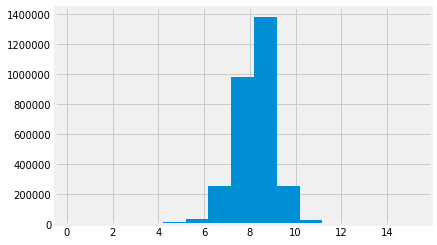

In [157]:
np.log(df_properties.taxamount+1).hist(bins=15)
# this looks much more reasonable

### check temporal behavior

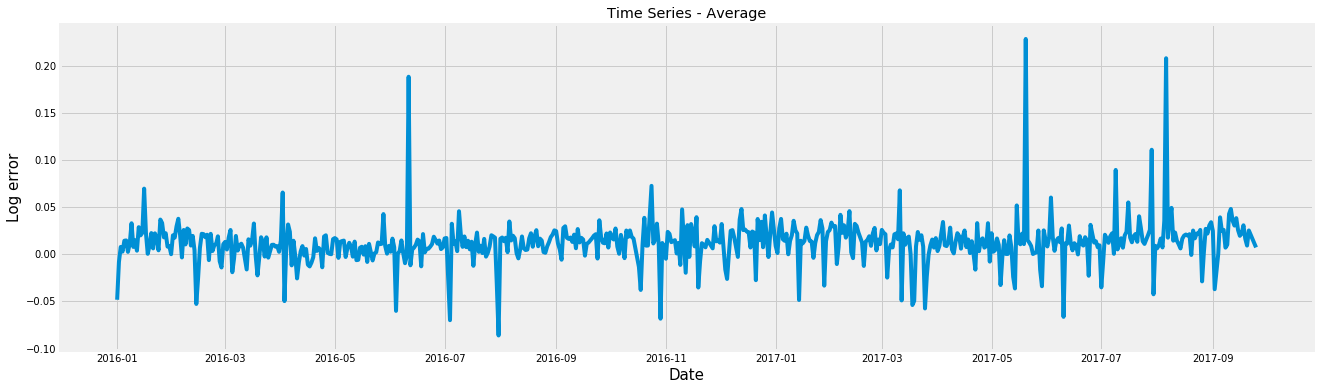

In [440]:
df['transaction_month'] = df['transactiondate'].dt.month
df['transaction_year'] = df['transactiondate'].dt.year
df['transaction_year_and_month'] = df['transactiondate'].astype('str').str[:7]

# train.set_index(pd.to_datetime(train.transactiondate), inplace = True)
df['transactiondate'] = pd.to_datetime(df.transactiondate)

mask = (df['transactiondate'] < '2017-10-01')
df1=df.loc[mask]

# first visualize the data
plt.figure(figsize=(20, 6))
mean_group = df1[['transactiondate','logerror']].groupby(['transactiondate'])['logerror'].mean()
plt.plot(mean_group)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Log error', fontsize=15)
plt.title('Time Series - Average')
plt.show() 


##### ARIMA Model

In [441]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 3) for x in list(itertools.product(p, d, q))]
# 12 months, 3, quarter
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 3)
SARIMAX: (0, 0, 1) x (0, 1, 0, 3)
SARIMAX: (0, 1, 0) x (0, 1, 1, 3)
SARIMAX: (0, 1, 0) x (1, 0, 0, 3)


In [442]:
# Akaike Information Criter AIC test
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(mean_group,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 3)12 - AIC:-2731.4595108
ARIMA(0, 0, 0)x(0, 1, 1, 3)12 - AIC:-2836.54814083
ARIMA(0, 0, 0)x(1, 0, 0, 3)12 - AIC:-2748.04993648
ARIMA(0, 0, 0)x(1, 0, 1, 3)12 - AIC:-2851.40159948
ARIMA(0, 0, 0)x(1, 1, 0, 3)12 - AIC:-2618.80077034
ARIMA(0, 0, 0)x(1, 1, 1, 3)12 - AIC:-2833.38938562
ARIMA(0, 0, 1)x(0, 0, 0, 3)12 - AIC:-2747.98290652
ARIMA(0, 0, 1)x(0, 0, 1, 3)12 - AIC:-2747.16420371
ARIMA(0, 0, 1)x(0, 1, 0, 3)12 - AIC:-2454.19993605
ARIMA(0, 0, 1)x(0, 1, 1, 3)12 - AIC:-2830.07375238
ARIMA(0, 0, 1)x(1, 0, 0, 3)12 - AIC:-2764.19480911
ARIMA(0, 0, 1)x(1, 0, 1, 3)12 - AIC:-2845.01455268
ARIMA(0, 0, 1)x(1, 1, 0, 3)12 - AIC:-2618.59967262
ARIMA(0, 0, 1)x(1, 1, 1, 3)12 - AIC:-2827.46804071
ARIMA(0, 1, 0)x(0, 0, 1, 3)12 - AIC:-2463.8584728
ARIMA(0, 1, 0)x(0, 1, 1, 3)12 - AIC:-2435.45436737
ARIMA(0, 1, 0)x(1, 0, 0, 3)12 - AIC:-2468.84719629
ARIMA(0, 1, 0)x(1, 0, 1, 3)12 - AIC:-2461.99686394
ARIMA(0, 1, 0)x(1, 1, 0, 3)12 - AIC:-2224.67214254
ARIMA(0, 1, 0)x(1, 1, 1, 3)12 - A

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0383      0.053      0.728      0.467      -0.065       0.141
ar.L2         -0.1326      0.042     -3.147      0.002      -0.215      -0.050
ma.L1         -1.9981      0.058    -34.271      0.000      -2.112      -1.884
ma.L2          0.9985      0.058     17.132      0.000       0.884       1.113
ar.S.L12      -0.4318      0.171     -2.518      0.012      -0.768      -0.096
ar.S.L24      -0.1320      0.093     -1.421      0.155      -0.314       0.050
ma.S.L12      -1.1726      0.165     -7.125      0.000      -1.495      -0.850
ma.S.L24       0.1837      0.177      1.039      0.299      -0.163       0.530
sigma2         0.0008   9.11e-05      8.622      0.000       0.001       0.001


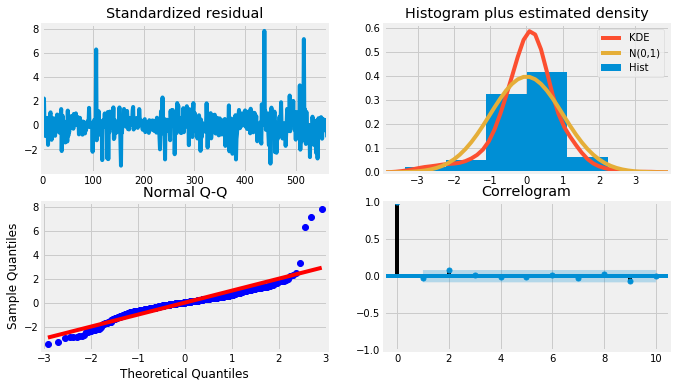

In [443]:
mod = sm.tsa.statespace.SARIMAX(mean_group.values,
                                order=(2, 2, 2),
                                seasonal_order=(2, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])
results.plot_diagnostics(figsize=(10, 6))
plt.show()

##### ARIMA Prediction

In [444]:
pred = results.get_prediction(start=0,dynamic=False)
y_forecasted = pred.predicted_mean
y_truth = mean_group[0:]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 5)))

The Mean Squared Error of our forecasts is 0.00109


In [445]:
pred_uc=results.get_forecast(steps=97)
forcast = pd.DataFrame( pred_uc.predicted_mean ) 
new_transactiondate = pd.date_range('2017-09-26', periods=97, freq='1D')
columns=[['transactiondate','logerror']]
forcast_from_oct17=pd.DataFrame(columns=columns)

forcast_from_oct17['transactiondate']=new_transactiondate
forcast_from_oct17['logerror']=forcast
forcast_from_oct17.dropna()
forcast_from_oct17.tail()

logerrors=pd.DataFrame( pred.predicted_mean ) 

prediction=pd.DataFrame(columns=columns)

prediction['transactiondate']=pd.to_datetime(mean_group.index)

prediction['logerror'] = logerrors

prediction.head()

data=pd.concat([prediction, forcast_from_oct17])
data.head()

,transactiondate,logerror
0,2016-01-01,0.000000
1,2016-01-02,-0.087249
2,2016-01-03,0.033399
3,2016-01-04,0.020659
4,2016-01-05,-0.001623


##### ARIMA Forcasting

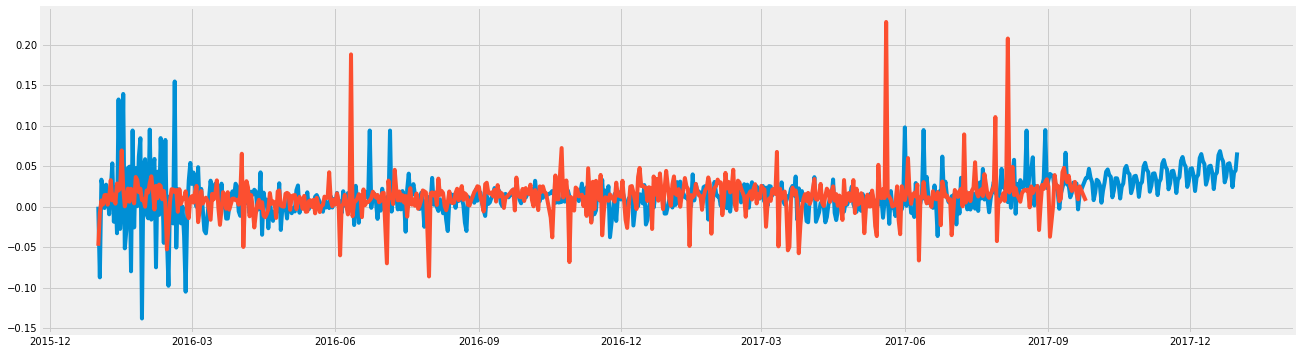

In [448]:
plt.figure(figsize=(20, 6))
xx=data.transactiondate
yy=data.logerror
plt.plot(xx, yy)
plt.plot(mean_group)

In [449]:
data.to_csv('/Users/fangjie/Workspace/data-science/competitions/arima_model_month.csv', index=False, float_format='%.6f') 

## Spatial feature

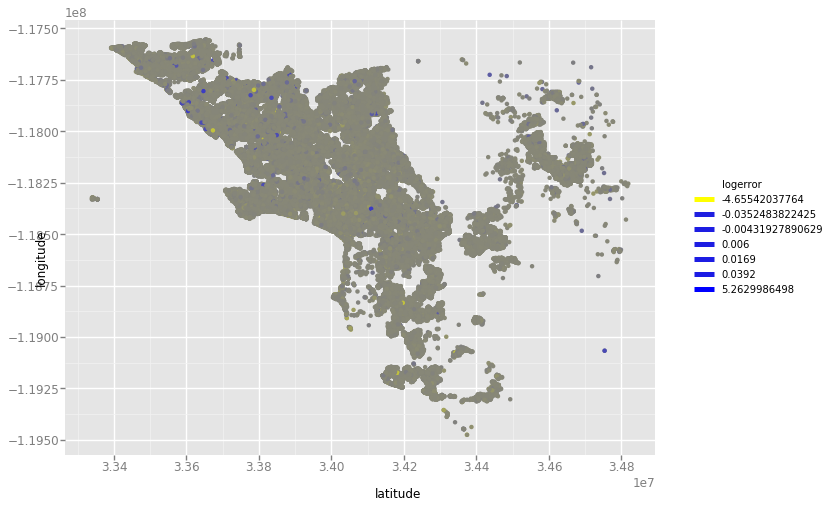

<ggplot: (373233801)>

In [450]:
# geographical logerror distribution
from ggplot import *
ggplot(aes(x='latitude', y='longitude', color='logerror'), data=df) + \
    geom_point() + \
    scale_color_gradient(low = 'yellow', high = 'blue')

<a id="section_4_e"></a>
## 4e.  generate training testing sets

In [425]:
mask_train.reset_index(drop=True, inplace = True)
mask_test.reset_index(drop=True, inplace = True)

feats.remove('f_num_stddev_logerror')
feats.remove('f_num_avg_logerror')

ValueError: list.remove(x): x not in list

In [420]:
# some extra filtering to remove outliers
mask_outlier = (df.logerror > 0.4) | (df.logerror < -0.4)
# mask_outlier = df.logerror > 999

X_train = df.loc[(mask_train & ~mask_outlier), feats].astype(float).values
X_test = df.loc[mask_test, feats].astype(float).values

y_train = np.array(df.loc[(mask_train & ~mask_outlier), 'logerror'].tolist())
y_test = np.array(df.loc[mask_test, 'logerror'].tolist())

ValueError: cannot reindex from a duplicate axis

ValueError: list.remove(x): x not in list

In [198]:
X_train = df.loc[mask_train, feats].astype(float).values
X_test = df.loc[mask_test, feats].astype(float).values

y_train = np.array(df.loc[mask_train, 'logerror'].tolist())
y_test = np.array(df.loc[mask_test, 'logerror'].tolist())

data = (X_train, X_test, y_train, y_test)

In [200]:
# save data
pickle.dump(data, open('/Users/fangjie/Workspace/data-science/competitions/zillow/training_and_testing_data.pkl', 'w'))

In [ ]:
mask_train.reset_index(drop=True, inplace = True)
mask_test.reset_index(drop=True, inplace = True)
feats.remove('f_num_stddev_logerror')
feats.remove('f_num_avg_logerror')
# X_train = df.loc[mask_train, feats].astype(float).values
# X_test = df.loc[mask_test, feats].astype(float).values


<a id="section_5"></a>
# 5. Train models

In [ ]:
np.random.seed(42)
random.seed(42)

<a id="section_5_a"></a>
## 5a. LightGBM

In [ ]:
params = {
    # 'max_bin': [10],
    'max_depth': [100],
    'num_leaves': [32],
    'feature_fraction': [0.85],
    'bagging_fraction': [0.95],
    'bagging_freq': [8],
    'learning_rate': [0.0025],
}

In [ ]:
start = time.time()
scorer = make_scorer(mean_absolute_error)
model = lgb.LGBMRegressor(boosting_type = 'gbdt', 
                          metric='mae', 
                          verbosity=0, 
                          #verbose_eval=200, 
                          num_boost_round=200,
                          #bagging_seed=42, 
                          #feature_fraction_seed=42,
                          n_jobs = 6
                          )
grid = GridSearchCV(model, params, scoring=scorer,
                          cv=3, verbose=2, n_jobs=6)
grid.fit(X_train, y_train)
print("[INFO] randomized search took {:.2f} seconds".format(
    time.time() - start))

In [ ]:
# prediction for test set and prediction set
y_pred = grid.predict(X_test)
# pred_lgb = grid.predict(X_pred_2016)

In [ ]:
mae = grid.score(X_test, y_test)
print("[INFO] grid search MAE: {:.6f}".format(mae))
print("[INFO] randomized search best parameters: {}".format(
    grid.best_params_))

In [ ]:
mae = grid.score(X_test, y_test)
print("[INFO] grid search MAE: {:.6f}".format(mae))
print("[INFO] randomized search best parameters: {}".format(
    grid.best_params_))

### make prediction

In [ ]:
results = pd.DataFrame()
results['ParcelId'] = df_pred_2016['ParcelId']

In [ ]:
df_train = df
#for m in [201610]:
for m in [201610, 201611, 201612, 201710, 201711, 201712]:
    print "now doing prediction for {} ...".format(str(m))
    year = str(m)[:4]
    month = str(m)[4:]
    
    # avg log error, monthly
    group = df_train.groupby(df_train.f_num_month)['logerror'].aggregate('mean').to_dict()
    eval('df_pred_'+year)['f_num_monthly_avg_logerror'] = group[int(month)]
                                   
    # std dev log error, monthly
    group = df_train.groupby(df_train.f_num_month)['logerror'].aggregate('std').to_dict()
    eval('df_pred_'+year)['f_num_monthly_stddev_logerror'] = group[int(month)]

    # avg log error, quarterly
    group = df_train.groupby(df_train.f_num_month)['logerror'].aggregate('mean').to_dict()
    eval('df_pred_'+year)['f_num_quarterly_avg_logerror'] = group[4]
    
    # std dev log error, monthly
    group = df_train.groupby(df_train.f_num_month)['logerror'].aggregate('std').to_dict()
    eval('df_pred_'+year)['f_num_quarterly_stddev_logerror'] = group[4]
    
    
    eval('df_pred_'+year)['f_num_month'] = int(month)
    eval('df_pred_'+year)['f_num_quarter'] = 4
    
    pred = grid.predict(eval('df_pred_'+year)[feats].astype(float).values)
    results[str(m)] = pred
    

In [ ]:
results.shape[0] == 2985217

In [ ]:
results.to_csv('/Users/fangjie/Workspace/data-science/competitions/zillow/submission_{}.csv'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S')), index=False, float_format = '%.5f')

<a id="section_5_b"></a>
## 5b. XgBoost

In [ ]:
# xgboost params
params = {
    'eta': 0.037,
    'max_depth': 5,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8,   
    'alpha': 0.4, 
    'base_score': np.mean(y_train),
    'silent': 1
}

In [ ]:
d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_test)
d_pred = xgb.DMatrix(X_pred)

In [ ]:
num_boost_rounds = 150
fit = xgb.train(dict(params, silent=1), d_train, num_boost_round=num_boost_rounds)

In [ ]:
# prediction for test set and prediction set
y_pred = fit.predict(d_test)
pred_xgb = fit.predict(d_pred)

In [ ]:
report_test_set_performance()

In [ ]:
# when not using oct data
report_test_set_performance()

<a id="section_5_c"></a>
## 5c. Random Forest

In [ ]:
params = {
    "max_depth": 10,
    "min_samples_split": 50,
    "n_estimators": 200
}

In [ ]:
fit = RandomForestRegressor(random_state=42, n_jobs=-1, verbose=1, **params)
fit.fit(X_train, y_train)

In [ ]:
# prediction for test set and prediction set
y_pred = fit.predict(X_test)
pred_rf = fit.predict(X_pred)

In [ ]:
report_test_set_performance()

<a id="section_5_d"></a>
## 5d. Elastic Net
For linear model, need to have different missing value imputation strategy.

In [ ]:
params = {
    'l1_ratio':0.7, 
}

In [ ]:
fit = ElasticNetCV(cv=5, random_state=42)
fit.fit(X_train, y_train)
ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=-1,
       normalize=False, positive=False, precompute='auto', random_state=0,
       selection='cyclic', tol=0.0001, verbose=0)

In [ ]:
# prediction for test set and prediction set
y_pred = fit.predict(X_test)
#pred_enet = fit.predict(X_pred)

In [ ]:
def report_test_set_performance():
    #explained_variance_score(y_pred=y_pred, y_true=y_test)
    print 'MAE:{}'.format(round(mean_absolute_error(y_pred=y_pred, y_true=y_test),6))
    # pd.Series(pred_lgb_test).hist()

In [ ]:
report_test_set_performance()

<a id="section_5_e"></a>
## 5e. CatBoost

In [ ]:
cat_feature_inds = []
cat_unique_thresh = 1000
for i, c in enumerate(feats_categorical):
    num_uniques = len(df[c].unique())
    if num_uniques < cat_unique_thresh \
       and not 'sqft' in c \
       and not 'cnt' in c \
       and not 'nbr' in c \
       and not 'number' in c:
        cat_feature_inds.append(i)

In [ ]:
num_ensembles = 5
y_pred = 0.0
for i in tqdm(range(num_ensembles)):
    model = CatBoostRegressor(
        iterations=300, learning_rate=0.03,
        depth=6, l2_leaf_reg=3,
        loss_function='MAE',
        eval_metric='MAE',
        random_seed=i)
    
    model.fit(
        X_train, y_train,
        #cat_features=cat_feature_inds
    )
    y_pred += model.predict(X_test)
y_pred /= num_ensembles


In [ ]:
report_test_set_performance()

<a id="section_6"></a>
# 6. Visualizations

<a id="section_7_a"></a>
# 7. Ensenmble - stacking

In [ ]:
model_weights = {
    'lgb': 1,
    'xgb': 0.00,
    'rf': 0.00,
    'enet': 0,
    'baseline': 0,
}

## Make predictions first for each model

In [ ]:
pred_all = 0
pred_baseline = df.logerror.mean()
for model_name, model_weight in model_weights.iteritems():
    pred_all += eval('pred_'+model_name) * model_weight
pred_all = pred_all / sum(model_weights.values())

# generate submission file

In [ ]:
df_submission = df[['parcelid','logerror']]
df_submission['pred'] = pred_all

In [ ]:
# df_submission['201610'] = df_submission['logerror'].combine_first(df_submission['pred'])
df_submission['201610'] = df_submission['pred']
df_submission['201611'] = df_submission['pred']
df_submission['201612'] = df_submission['pred']
df_submission['201710'] = df_submission['pred']
df_submission['201711'] = df_submission['pred']
df_submission['201712'] = df_submission['pred']

In [ ]:
df_submission.drop_duplicates(subset = ['parcelid'], keep='first', inplace = True)

In [ ]:
del df_submission['logerror']
del df_submission['pred']